# Multi-source Friedman Experiments

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import torch 
import torch.nn as nn
from matplotlib.pyplot import cm
from models.hdisc_msda import Disc_MSDANet, weighted_mse
from utils.utils_hdisc import batch_loader, split_source_target, val_split
from sklearn.manifold import TSNE
from utils.toy_friedman import friedman, generate_x_friedman, generate_y_friedman, generate_x_friedman_clusters


In [2]:
N = 500
n_domains = 10
X = np.zeros((n_domains, N, 5))
alpha = np.array([1,1,1,1,1,1,0,0,0])
alpha = alpha/np.sum(alpha)
clusters = np.array([0,0,0,1,1,1,2,2,2])

X = generate_x_friedman_clusters(n_domains = 10, N = 100, alpha = alpha, noise=0.15, clusters = clusters, cluster_noise=0.1,
                        target_shift_mean=0.5, target_shift_std=0.1, random_state = 42)
y = generate_y_friedman(X, normalize = True, random_state = 0)


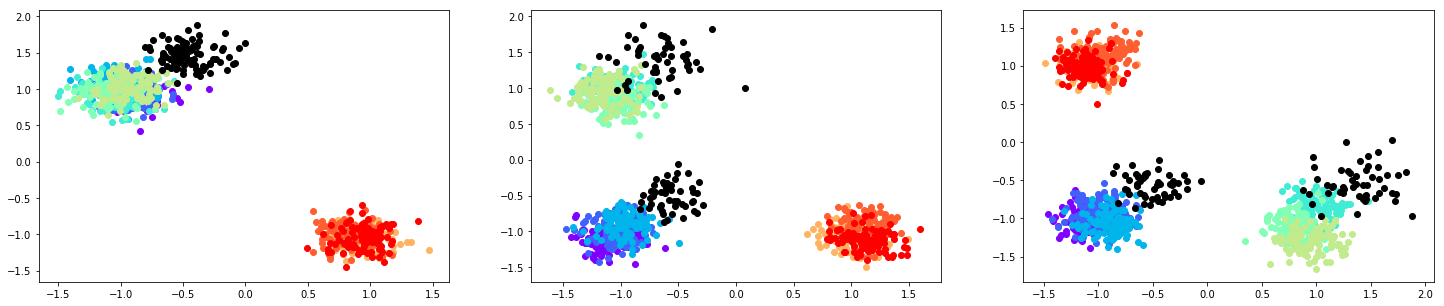

In [3]:
plt.figure(figsize=(25,5))
color=iter(cm.rainbow(np.linspace(0,1,n_domains-1)))
plt.subplot(1,3,1)
for i in range(n_domains-1):
    c=next(color)
    plt.scatter(X[i,:,1], X[i,:,2], c=c, label=str(i))
plt.scatter(X[-1,:,1], X[-1,:,2], c='k', label=str(9))
color=iter(cm.rainbow(np.linspace(0,1,n_domains-1)))
plt.subplot(1,3,2)
for i in range(n_domains-1):
    c=next(color)
    plt.scatter(X[i,:,3], X[i,:,4], c=c, label=str(i))
plt.scatter(X[-1,:,3], X[-1,:,4], c='k', label=str(9))
color=iter(cm.rainbow(np.linspace(0,1,n_domains-1)))
plt.subplot(1,3,3)
for i in range(n_domains-1):
    c=next(color)
    plt.scatter(X[i,:,4], X[i,:,0], c=c, label=str(i))
plt.scatter(X[-1,:,4], X[-1,:,0], c='k', label=str(9))
plt.savefig('./plots/friedman/multiple_source_data.jpg', transparent=True)
plt.show()


## Experiments

In [4]:
def get_feature_extractor():
    return nn.ModuleList([
            nn.Linear(5, 10, bias=False), nn.ELU(), nn.Dropout(p=0.2),

            nn.Linear(10, 5, bias=False), nn.Dropout(p=0.2)])

def get_predictor(output_dim=1):
    return  nn.ModuleList([
            nn.Linear(5, output_dim, bias=False)])

def get_discriminator(output_dim=1):
    return nn.ModuleList([
            nn.Linear(5, output_dim, bias=False)])
full_logs = {}
full_feats = {}
full_w = {}

### 1. No Adaptation

In [5]:
mode = 'MLP'
seed = 0
#Set seed
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic=True
#Parameters of training
epochs = 150
device = torch.device('cuda:0')
lr, momentum = 0.001, 0.9
batch_size = 32
keep_best = True

#Model
params= {'input_dim': 5, 'output_dim': 1, 'n_sources': 9, 'loss': torch.nn.MSELoss(),
         'weighted_loss': weighted_mse, 'min_pred': -np.inf, 'max_pred':np.inf}
params['feature_extractor'] = get_feature_extractor()
params['h_pred'] = get_predictor(output_dim=1)
params['h_disc'] = get_discriminator(output_dim=1)
clip = 1
target = n_domains - 1

#Split source and target
X_s, X_t, y_s, y_t = split_source_target(X, y, target, device, merge=False)
#Validation split
X_train, X_val, y_train, y_val = val_split(X_s, y_s)
model = Disc_MSDANet(params).to(device)
opt_feat = torch.optim.SGD([{'params': model.feature_extractor.parameters()}],lr=lr, momentum=momentum)
opt_pred = torch.optim.SGD([{'params': model.feature_extractor.parameters()}],lr=lr, momentum=momentum)
opt_disc =torch.optim.SGD([{'params': model.h_disc.parameters()}],lr=lr, momentum=momentum)
opt_alpha =torch.optim.SGD([{'params': model.alpha}],lr=lr, momentum=momentum)
model.optimizers(opt_feat, opt_pred, opt_disc, opt_alpha)
#Logs
reg_train_loss, reg_val_loss, reg_test_loss = [], [], []
current_val_loss = np.inf
for epoch in range(epochs):
    model.train()
    loader = batch_loader(X_train, y_train ,batch_size = batch_size)
    for x_bs, y_bs in loader:
        loss_pred = model.train_prediction(x_bs, X_t, y_bs, clip=clip, pred_only=False)
        #model.train_h_disc_pred(x_bs, X_t, y_bs, clip=clip)
    #Validation
    model.eval()
    val_loss, _ = model.compute_loss(X_val, X_t, y_val)
    source_loss, disc = model.compute_loss(X_s, X_t, y_s)
    reg_loss = model.loss(y_t, model.predict(X_t))
    reg_train_loss.append(source_loss.item())
    reg_test_loss.append(reg_loss.item())
    reg_val_loss.append(val_loss.item())
    
    if (val_loss.item()<current_val_loss)*(keep_best):
        current_val_loss = val_loss.item()
        best_mse = model.loss(y_t, model.predict(X_t))
    if (epoch+1)%10==0:
        model.eval()
        print('Epoch: %i/%i ; Train loss: %.3f ; Validation loss: %.3f Test loss: %.3f'%(epoch+1, epochs, source_loss.item(), val_loss.item(), reg_loss.item()))

full_logs[mode] = [reg_train_loss, reg_val_loss, reg_test_loss]
full_feats[mode] = np.array([model.extract_features(torch.Tensor(X[i]).to(device)).cpu().detach().numpy() for i in range(n_domains)])
full_w[mode] = list(model.h_pred.parameters())[0]

Epoch: 10/150 ; Train loss: 0.673 ; Validation loss: 0.677 Test loss: 0.174
Epoch: 20/150 ; Train loss: 0.376 ; Validation loss: 0.381 Test loss: 0.358
Epoch: 30/150 ; Train loss: 0.193 ; Validation loss: 0.198 Test loss: 0.608
Epoch: 40/150 ; Train loss: 0.134 ; Validation loss: 0.138 Test loss: 0.779
Epoch: 50/150 ; Train loss: 0.128 ; Validation loss: 0.131 Test loss: 0.790
Epoch: 60/150 ; Train loss: 0.130 ; Validation loss: 0.133 Test loss: 0.760
Epoch: 70/150 ; Train loss: 0.127 ; Validation loss: 0.130 Test loss: 0.757
Epoch: 80/150 ; Train loss: 0.123 ; Validation loss: 0.126 Test loss: 0.765
Epoch: 90/150 ; Train loss: 0.120 ; Validation loss: 0.123 Test loss: 0.771
Epoch: 100/150 ; Train loss: 0.119 ; Validation loss: 0.122 Test loss: 0.767
Epoch: 110/150 ; Train loss: 0.116 ; Validation loss: 0.119 Test loss: 0.775
Epoch: 120/150 ; Train loss: 0.114 ; Validation loss: 0.118 Test loss: 0.777
Epoch: 130/150 ; Train loss: 0.114 ; Validation loss: 0.118 Test loss: 0.771
Epoch: 1

### 2. Multiple Sources HDisc

In [6]:
import importlib
import models.hdisc_msda 
importlib.reload(models.hdisc_msda)
from models.hdisc_msda import Disc_MSDANet

mode = 'AHDA'
#Set seed
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic=True

#Parameters of training
epochs_adapt = 150
epochs_h_disc, epochs_feat, epochs_pred, epochs_alpha = 1, 1, 1, 1
device = torch.device('cuda:0')
lr, momentum = 0.001, 0.9
batch_size = 32
keep_best = True

#Model
params= {'input_dim': 5, 'output_dim': 1, 'n_sources': 9, 'loss': torch.nn.MSELoss(),
         'weighted_loss': weighted_mse, 'min_pred': -np.inf, 'max_pred':np.inf}
params['feature_extractor'] = get_feature_extractor()
params['h_pred'] = get_predictor(output_dim=1)
params['h_disc'] = get_discriminator(output_dim=1)
clip = 1
target = n_domains - 1

disc_adapt = []

#Split source and target
X_s, X_t, y_s, y_t = split_source_target(X, y, target, device, merge=False)
#Validation split
X_train, X_val, y_train, y_val = val_split(X_s, y_s)
model = Disc_MSDANet(params).to(device)
opt_feat = torch.optim.SGD([{'params': model.feature_extractor.parameters()}],lr=lr, momentum=momentum)
opt_pred = torch.optim.SGD([{'params': model.h_pred.parameters()}],lr=lr, momentum=momentum)
opt_disc =torch.optim.SGD([{'params': model.h_disc.parameters()}],lr=lr, momentum=momentum)
opt_alpha =torch.optim.SGD([{'params': model.alpha}],lr=lr, momentum=momentum)
model.optimizers(opt_feat, opt_pred, opt_disc, opt_alpha)
#Logs
reg_train_loss, reg_val_loss, reg_test_loss = [], [], []
current_val_loss = np.inf
#Alternated training
print('------------Alternated training------------')
for epoch in range(epochs_adapt):
    model.train()
    loader = batch_loader(X_s, y_s ,batch_size = batch_size)
    for x_bs, y_bs in loader:
        ridx = np.random.choice(X_t.shape[0], batch_size)
        x_bt = X_t[ridx,:]
        #Train h to minimize source loss
        for e in range(epochs_pred):
            model.train_prediction(x_bs, x_bt, y_bs, pred_only=False,clip=clip)

        #Train h' to maximize discrepancy
        for e in range(epochs_h_disc):
            model.train_h_discrepancy(x_bs, x_bt, y_bs, clip=clip)
        
        #Train phi to minimize discrepancy
        for e in range(epochs_feat):
            model.train_feat_discrepancy(x_bs, x_bt, y_bs, mu=0,clip=clip)
                        

    #Validation
    model.eval()
    val_loss, _ = model.compute_loss(X_val, X_t, y_val)
    source_loss, disc = model.compute_loss(X_s, X_t, y_s)
    reg_loss = model.loss(y_t, model.predict(X_t))
    reg_train_loss.append(source_loss.item())
    reg_test_loss.append(reg_loss.item())
    reg_val_loss.append(val_loss.item())
    disc_adapt.append(disc.item())
    if (val_loss.item()<current_val_loss)*(keep_best):
        current_val_loss = val_loss.item()
        best_mse = model.loss(y_t, model.predict(X_t))
    if (epoch+1)%10==0:
        model.eval()
        print('Epoch: %i/%i ; Train loss: %.3f ; Validation loss: %.3f Test loss: %.3f'%(epoch+1, epochs_adapt, source_loss.item(), val_loss.item(), reg_loss.item()))
full_logs[mode] = [reg_train_loss, reg_val_loss, reg_test_loss]
full_feats[mode] = np.array([model.extract_features(torch.Tensor(X[i]).to(device)).cpu().detach().numpy() for i in range(n_domains)])
full_w[mode] = list(model.h_pred.parameters())[0]


------------Alternated training------------
Epoch: 10/150 ; Train loss: 0.864 ; Validation loss: 0.710 Test loss: 0.118
Epoch: 20/150 ; Train loss: 0.748 ; Validation loss: 0.606 Test loss: 0.155
Epoch: 30/150 ; Train loss: 0.574 ; Validation loss: 0.451 Test loss: 0.248
Epoch: 40/150 ; Train loss: 0.438 ; Validation loss: 0.334 Test loss: 0.358
Epoch: 50/150 ; Train loss: 0.310 ; Validation loss: 0.227 Test loss: 0.535
Epoch: 60/150 ; Train loss: 0.214 ; Validation loss: 0.156 Test loss: 0.754
Epoch: 70/150 ; Train loss: 0.174 ; Validation loss: 0.130 Test loss: 0.878
Epoch: 80/150 ; Train loss: 0.152 ; Validation loss: 0.117 Test loss: 0.947
Epoch: 90/150 ; Train loss: 0.145 ; Validation loss: 0.112 Test loss: 0.935
Epoch: 100/150 ; Train loss: 0.142 ; Validation loss: 0.108 Test loss: 0.922
Epoch: 110/150 ; Train loss: 0.137 ; Validation loss: 0.105 Test loss: 0.917
Epoch: 120/150 ; Train loss: 0.133 ; Validation loss: 0.103 Test loss: 0.913
Epoch: 130/150 ; Train loss: 0.130 ; Vali

## 3. AHD-MSDA

In [7]:
import importlib
import models.hdisc_msda 
importlib.reload(models.hdisc_msda)
from models.hdisc_msda import Disc_MSDANet

mode = 'AHD-MSDA'
#Set seed
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic=True

#Parameters of training
epochs_adapt = 150
epochs_h_disc, epochs_feat, epochs_pred, epochs_alpha = 1, 1, 1, 1
device = torch.device('cuda:0')
lr, momentum = 0.001, 0.9
batch_size = 32
keep_best = True

#Model
params= {'input_dim': 5, 'output_dim': 1, 'n_sources': 9, 'loss': torch.nn.MSELoss(),
         'weighted_loss': weighted_mse, 'min_pred': -np.inf, 'max_pred':np.inf}
params['feature_extractor'] = get_feature_extractor()
params['h_pred'] = get_predictor(output_dim=1)
params['h_disc'] = get_discriminator(output_dim=1)
clip = 1
target = n_domains - 1

disc_adapt = []

#Split source and target
X_s, X_t, y_s, y_t = split_source_target(X, y, target, device, merge=False)
#Validation split
X_train, X_val, y_train, y_val = val_split(X_s, y_s)
model = Disc_MSDANet(params).to(device)
opt_feat = torch.optim.SGD([{'params': model.feature_extractor.parameters()}],lr=lr, momentum=momentum)
opt_pred = torch.optim.SGD([{'params': model.h_pred.parameters()}],lr=lr, momentum=momentum)
opt_disc =torch.optim.SGD([{'params': model.h_disc.parameters()}],lr=lr, momentum=momentum)
opt_alpha =torch.optim.SGD([{'params': model.alpha}],lr=lr, momentum=momentum)
model.optimizers(opt_feat, opt_pred, opt_disc, opt_alpha)
#Logs
reg_train_loss, reg_val_loss, reg_test_loss = [], [], []
current_val_loss = np.inf
#Alternated training
print('------------Alternated training------------')
for epoch in range(epochs_adapt):
    model.train()
    loader = batch_loader(X_s, y_s ,batch_size = batch_size)
    for x_bs, y_bs in loader:
        ridx = np.random.choice(X_t.shape[0], batch_size)
        x_bt = X_t[ridx,:]
        #Train h to minimize source loss
        for e in range(epochs_pred):
            model.train_prediction(x_bs, x_bt, y_bs, pred_only=False,clip=clip)

        #Train h' to maximize discrepancy
        for e in range(epochs_h_disc):
            model.train_h_discrepancy(x_bs, x_bt, y_bs, clip=clip)
        
        #Train phi to minimize discrepancy
        for e in range(epochs_feat):
            model.train_feat_discrepancy(x_bs, x_bt, y_bs, mu=0,clip=clip)
            
        #Train phi to minimize discrepancy
        for e in range(epochs_alpha):
            model.train_alpha_discrepancy(x_bs, x_bt, y_bs, lam_alpha=0.1, clip=1)
            

    #Validation
    model.eval()
    val_loss, _ = model.compute_loss(X_val, X_t, y_val)
    source_loss, disc = model.compute_loss(X_s, X_t, y_s)
    reg_loss = model.loss(y_t, model.predict(X_t))
    reg_train_loss.append(source_loss.item())
    reg_test_loss.append(reg_loss.item())
    reg_val_loss.append(val_loss.item())
    disc_adapt.append(disc.item())
    if (val_loss.item()<current_val_loss)*(keep_best):
        current_val_loss = val_loss.item()
        best_mse = model.loss(y_t, model.predict(X_t))
    if (epoch+1)%10==0:
        model.eval()
        print('Epoch: %i/%i ; Train loss: %.3f ; Validation loss: %.3f Test loss: %.3f'%(epoch+1, epochs_adapt, source_loss.item(), val_loss.item(), reg_loss.item()))
full_logs[mode] = [reg_train_loss, reg_val_loss, reg_test_loss]
full_feats[mode] = np.array([model.extract_features(torch.Tensor(X[i]).to(device)).cpu().detach().numpy() for i in range(n_domains)])
full_w[mode] = list(model.h_pred.parameters())[0]


------------Alternated training------------
Epoch: 10/150 ; Train loss: 0.805 ; Validation loss: 0.830 Test loss: 0.119
Epoch: 20/150 ; Train loss: 0.634 ; Validation loss: 0.652 Test loss: 0.168
Epoch: 30/150 ; Train loss: 0.497 ; Validation loss: 0.511 Test loss: 0.224
Epoch: 40/150 ; Train loss: 0.338 ; Validation loss: 0.347 Test loss: 0.334
Epoch: 50/150 ; Train loss: 0.225 ; Validation loss: 0.231 Test loss: 0.450
Epoch: 60/150 ; Train loss: 0.149 ; Validation loss: 0.153 Test loss: 0.565
Epoch: 70/150 ; Train loss: 0.110 ; Validation loss: 0.111 Test loss: 0.626
Epoch: 80/150 ; Train loss: 0.093 ; Validation loss: 0.094 Test loss: 0.634
Epoch: 90/150 ; Train loss: 0.080 ; Validation loss: 0.080 Test loss: 0.629
Epoch: 100/150 ; Train loss: 0.074 ; Validation loss: 0.075 Test loss: 0.596
Epoch: 110/150 ; Train loss: 0.075 ; Validation loss: 0.076 Test loss: 0.569
Epoch: 120/150 ; Train loss: 0.072 ; Validation loss: 0.074 Test loss: 0.572
Epoch: 130/150 ; Train loss: 0.072 ; Vali

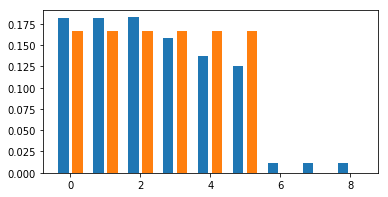

In [8]:
plt.figure(figsize=(6,3))
plt.bar(np.arange(9)-0.2, model.alpha.cpu().detach().numpy(), width=0.3)
plt.bar(np.arange(9)+0.2, alpha, width=0.3)
plt.savefig('./plots/friedman/alpha.jpg', transparent=True)
plt.show()